# Homework 2, *part 1* (40 points)

This warm-up problem set is provided to help you get used to PyTorch.

Please, only fill parts marked with "`Your code here`".

In [222]:
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

import torch
assert torch.__version__ >= '1.0.0'

import tqdm

To learn best practices $-$ for example,

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use,

$-$ you are expected to google a lot, read tutorials on the Web and study documentation.

Quick documentation on functions and modules is available with `?` and `help()`, like so:

In [2]:
help(torch.sqrt)

Help on built-in function sqrt:

sqrt(...)
    sqrt(input, out=None) -> Tensor
    
    Returns a new tensor with the square-root of the elements of :attr:`input`.
    
    .. math::
        \text{out}_{i} = \sqrt{\text{input}_{i}}
    
    Args:
        input (Tensor): the input tensor
        out (Tensor, optional): the output tensor
    
    Example::
    
        >>> a = torch.randn(4)
        >>> a
        tensor([-2.0755,  1.0226,  0.0831,  0.4806])
        >>> torch.sqrt(a)
        tensor([    nan,  1.0112,  0.2883,  0.6933])



In [3]:
# to close the Jupyter help bar, press `Esc` or `q`
?torch.cat

Docstring:
cat(tensors, dim=0, out=None) -> Tensor

Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
All tensors must either have the same shape (except in the concatenating
dimension) or be empty.

:func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
and :func:`torch.chunk`.

:func:`torch.cat` can be best understood via examples.

Args:
    tensors (sequence of Tensors): any python sequence of tensors of the same type.
        Non-empty tensors provided must have the same shape, except in the
        cat dimension.
    dim (int, optional): the dimension over which the tensors are concatenated
    out (Tensor, optional): the output tensor

Example::

    >>> x = torch.randn(2, 3)
    >>> x
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497]])
    >>> torch.cat((x, x, x), 0)
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497],
            [ 0.6580, -1.0969, -0.4614],
        

## Task 1 (3 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

*Clarification update:*

1. *you mustn't emulate PyTorch tensors with lists or tuples. Using a list for scaffolding utilities not provided by PyTorch core (e.g. to store model's layers or to group function arguments) is OK;*
2. *no loops*;
3. *you mustn't use numpy or other tensor libraries except PyTorch.*

$\rho(\theta)$ is defined in polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these values.
3. Convert it into Cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [2]:
theta = torch.linspace(-math.pi, math.pi, 1000)
assert theta.shape == (1000,)

rho = (1 + 0.9 * torch.cos(8 * theta)) * (1 + 0.1 * torch.cos(24 * theta)) * (0.9 + 0.05 * torch.cos(200 * theta)) * (1 + torch.sin(theta))
assert torch.is_same_size(rho, theta)

x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

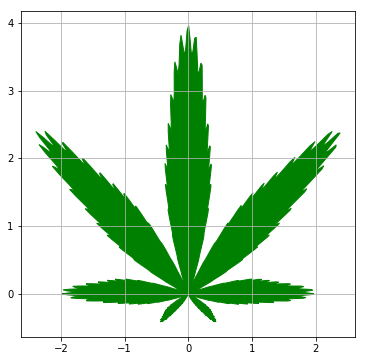

In [3]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

## Task 2 (7 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

*Clarification update: see task 1.*

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

If you skipped the URL above, here are the rules:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* At one step in time, the generation update happens:
  * Any living cell that has 2 or 3 neighbors survives, otherwise (0,1 or 4+ neighbors) it dies
  * Any cell with exactly 3 neighbors becomes alive if it was dead

You are given a reference numpy implementation of the update step. Your task is to convert it to PyTorch.

In [4]:
from scipy.signal import correlate2d as conv2d

def numpy_update(alive_map):
    # Count neighbours with convolution
    conv_kernel = np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]])
    
    num_alive_neighbors = conv2d(alive_map, conv_kernel, mode='same')
    
    # Apply game rules
    born = np.logical_and(num_alive_neighbors == 3, alive_map == 0)
    survived = np.logical_and(np.isin(num_alive_neighbors, [2,3]), alive_map == 1)
    
    np.copyto(alive_map, np.logical_or(born, survived))

In [18]:
def torch_update(alive_map):
    """
    Game of Life update function that does to `alive_map` exactly the same as `numpy_update`.
    
    :param alive_map: `torch.tensor` of shape `(height, width)` and dtype `torch.float32`
        containing 0s (dead) an 1s (alive)
    """
    conv_kernel = torch.Tensor([[[[1, 1, 1], [1, 0, 1], [1, 1, 1]]]])
    
    neighbors_map = torch.conv2d(alive_map.unsqueeze(0).unsqueeze(0),
                                 conv_kernel, padding=1).squeeze()
    born = (neighbors_map == 3) & (alive_map == 0)
    survived = ((neighbors_map == 2) | (neighbors_map == 3)) & (alive_map == 1)
        
    alive_map.copy_(born | survived)

In [19]:
# Generate a random initial map
alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
alive_map_torch = torch.tensor(alive_map_numpy).float().clone()

numpy_update(alive_map_numpy)
torch_update(alive_map_torch)

# results should be identical
assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
    "Your PyTorch implementation doesn't match numpy_update."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


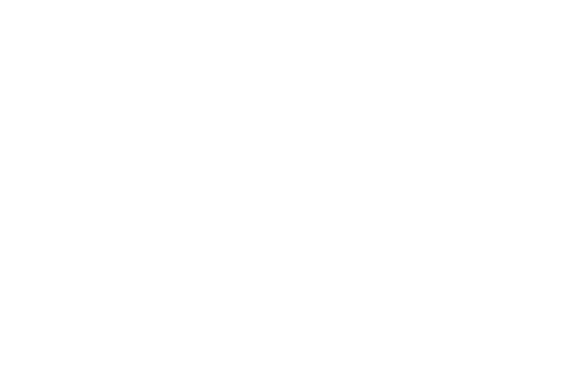

<IPython.core.display.Javascript object>


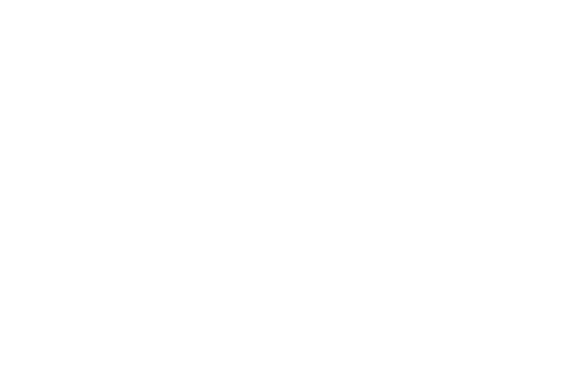

In [20]:
%matplotlib notebook
plt.ion()

# initialize game field
alive_map = np.random.choice([0, 1], size=(100, 100))
alive_map = torch.tensor(alive_map).float()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    torch_update(alive_map)
    
    # re-draw image
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>


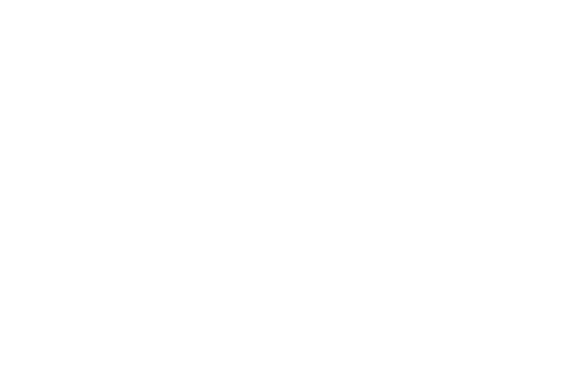

<IPython.core.display.Javascript object>


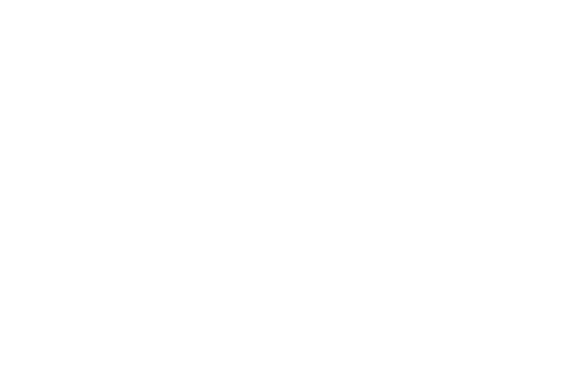

In [21]:
# A fun setup for your amusement
alive_map = np.arange(100) % 2 + np.zeros([100, 100])
alive_map[48:52, 50] = 1

alive_map = torch.tensor(alive_map).float()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(150):
    torch_update(alive_map)
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

## Task 3 (30 points)

You have to solve yet another character recognition problem: 10 letters, ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% accuracy
2. at least 2 linear layers
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

**You are NOT allowed to use**
* numpy arrays
* `torch.nn`, `torch.optim`, `torch.utils.data.DataLoader`
* convolutions

##### Clarification update:

1. *you mustn't emulate PyTorch tensors with lists or tuples. Using a list for scaffolding utilities not provided by PyTorch core (e.g. to store model's layers or to group function arguments) is OK;*
2. *you mustn't use numpy or other tensor libraries except PyTorch;*
3. *the purpose of part 1 is to make you google and read the documentation a LOT so that you learn which intrinsics PyTorch provides and what are their interfaces. This is why if there is some tensor functionality that is directly native to PyTorch, you mustn't emulate it with loops. Example:*

```
x = torch.rand(1_000_000)

# Wrong: slow and unreadable
for idx in range(x.numel()):
    x[idx] = math.sqrt(x[idx])

# Correct
x.sqrt_()
```

4. *Loops are prohibited except for iterating over*

  * *parameters (and their companion tensors used by optimizer, e.g. running averages),*
  * *layers,*
  * *epochs (or "global" gradient steps if you don't use epoch logic),*
  * *batches in the dataset (using loops for collecting samples into a batch is not allowed).*

Tips:

* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

**Reproducibility requirement**: you have to format your code cells so that `Cell -> Run All` on a fresh notebook **reliably** trains your model to the desired accuracy in a couple of minutes and reports the accuracy reached.

Happy googling!

In [295]:
np.random.seed(666)
torch.manual_seed(666)

from notmnist import load_notmnist
letters = 'ABCDEFGHIJ' 
X_train, y_train, X_test, y_test = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_test.squeeze_();

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]


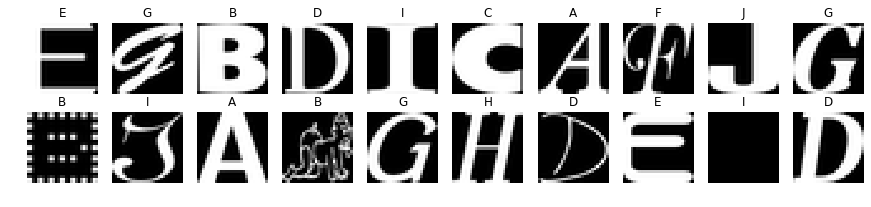

In [296]:
%matplotlib inline

fig, axarr = plt.subplots(2, 10, figsize=(15,3))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx].numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [297]:
class NeuralNet:
    def __init__(self, lr):
        # Your code here
        self.lr = lr
        self.EPS = 1e-15
        
        # First linear layer
        self.linear1w = torch.randn(784, 300, dtype=torch.float32, requires_grad=True)
        self.linear1b = torch.randn(1, 300, dtype=torch.float32, requires_grad=True)
        
        # Second linear layer
        self.linear2w = torch.randn(300, 10, dtype=torch.float32, requires_grad=True)
        self.linear2b = torch.randn(1, 10, dtype=torch.float32, requires_grad=True)
    
    def predict(self, images):
        """
        images: `torch.tensor` of shape `batch_size x height x width`
            and dtype `torch.float32`.
        
        returns: `output`, a `torch.tensor` of shape `batch_size x 10`,
            where `output[i][j]` is the probability of `i`-th
            batch sample to belong to `j`-th class.
        """
        def log_softmax(input):
            input = input - torch.max(input, dim=1, keepdim=True)[0]
            return input - torch.log(torch.sum(torch.exp(input), dim=1, keepdim=True))

        linear1_out = torch.add(images @ self.linear1w, self.linear1b).clamp(min=0)
        linear2_out = torch.add(linear1_out @ self.linear2w, self.linear2b)
        return log_softmax(linear2_out)
        
    def get_loss(self, input, target):

        def nll(input, target):
            return -torch.sum(target * input) /input.shape[0]
        
        return nll(input, target)
    
    def zero_grad(self):
        with torch.no_grad():
            self.linear1w.grad.zero_()
            self.linear1b.grad.zero_()
            self.linear2w.grad.zero_()
            self.linear2b.grad.zero_()        
        
    def update_weights(self, loss):
        loss.backward()
        
        with torch.no_grad():
            self.linear1w -= self.lr * self.linear1w.grad
            self.linear1b -= self.lr * self.linear1b.grad
            
            self.linear2w -= self.lr * self.linear2w.grad
            self.linear2b -= self.lr * self.linear2b.grad
            
            self.zero_grad()            

Define subroutines for one-hot encoding, accuracy calculating and batch generating:

In [298]:
def one_hot_encode(input, classes=10):
    return torch.eye(classes)[input]

In [299]:
def accuracy(model, images, labels):
    """
    model: `NeuralNet`
    images: `torch.tensor` of shape `N x height x width`
        and dtype `torch.float32`
    labels: `torch.tensor` of shape `N` and dtype `torch.int64`. Contains
        class index for each sample
    
    returns:
        fraction of samples from `images` correctly classified by `model`
    """
    with torch.no_grad():
        labels_pred = model.predict(images)
        numbers = labels_pred.argmax(dim=-1)
        numbers_target = labels.argmax(dim=-1)
        return (numbers == numbers_target).float().mean()

In [300]:
class batch_generator:
    def __init__(self, images, batch_size):
        dataset_size = images[0].size()[0]
        permutation = torch.randperm(dataset_size)
        self.images = images[0][permutation]
        self.targets = images[1][permutation]
        
        self.images = self.images.split(batch_size, dim=0)
        self.targets = self.targets.split(batch_size, dim=0)
        
        self.current = 0
        self.high = len(self.targets)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current >= self.high:
            raise StopIteration
        else:
            self.current += 1
            return self.images[self.current - 1], self.targets[self.current - 1]

Prepare dataset: reshape and one-hot encode:

In [301]:
train_size, _, _ = X_train.shape
test_size, _, _ = X_test.shape
X_train = X_train.reshape(train_size, -1)
X_test = X_test.reshape(test_size, -1)

y_train_oh = one_hot_encode(y_train)
y_test_oh = one_hot_encode(y_test)

print("Train size: ", X_train.shape)
print("Test size: ", X_test.shape)

Train size:  torch.Size([14043, 784])
Test size:  torch.Size([4681, 784])


Define model and train

In [302]:
model = NeuralNet(1e-2)
batch_size = 256
epochs = 50
loss_history = torch.Tensor(epochs)

for epoch in tqdm.trange(epochs):
    # Update weights
    for X_batch, y_batch in batch_generator((X_train, y_train_oh), batch_size):
        predicted = model.predict(X_batch)
        loss = model.get_loss(predicted, y_batch)
        model.update_weights(loss)
    # Calculate loss
    test_predicted = model.predict(X_test)
    loss = model.get_loss(test_predicted, y_test_oh)
    loss_history[epoch] = loss
    model.zero_grad()

100%|██████████| 50/50 [00:27<00:00,  1.62it/s]


Plot loss:

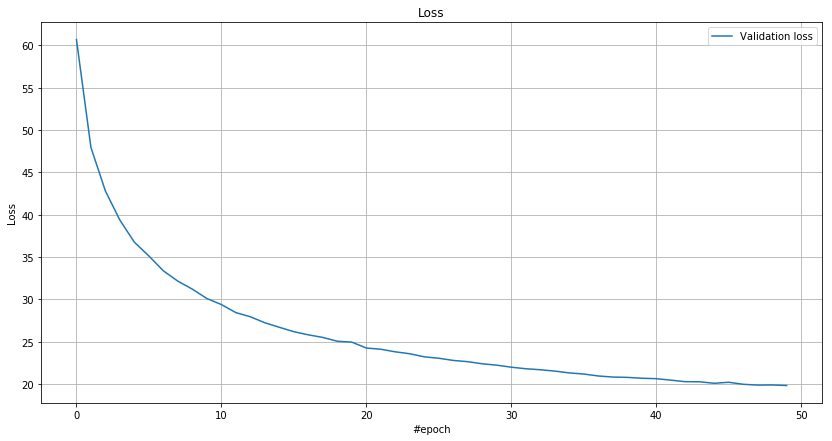

In [303]:
plt.figure(figsize=(14, 7))  
plt.title("Loss")
plt.xlabel("#epoch")
plt.ylabel("Loss")
plt.plot(loss_history.detach().numpy(), label="Validation loss")
plt.legend(loc='best')
plt.grid()
plt.show()

Final evalutation:

In [304]:
train_acc = accuracy(model, X_train, y_train_oh) * 100
test_acc = accuracy(model, X_test, y_test_oh) * 100
print("Train accuracy: %.2f, test accuracy: %.2f" % (train_acc, test_acc))

assert test_acc >= 82.0, "You have to do better"

Train accuracy: 93.09, test accuracy: 85.52
